# Active Learning Spectrally Normalized Deep Gaussian Process Regression Monte Carlo Simulation

https://docs.gpytorch.ai/en/latest/examples/01_Exact_GPs/Simple_GP_Regression.html

https://docs.gpytorch.ai/en/stable/examples/06_PyTorch_NN_Integration_DKL/KISSGP_Deep_Kernel_Regression_CUDA.html

In [1]:
from core.AL import AL
from core.utils.plot_utils import results_plot, results_print

In [2]:
EXAMPLE = 'example1'

## Start structural reliability assessment and Active Learning procedure


Iteration 0
Hyperparameters: [1], SN: True, act_fun: ReLU
Best Loss: 1.627850353717804 at epoch 990. Training loss: 1.7121527194976807 and val. loss: 1.5435479879379272
  Training succeeded after 1 attempt(s).
avg loss = 1.6279
  New best model found at fold 1:
    layer sizes: [1], act fun: <class 'torch.nn.modules.activation.ReLU'>

Fold: 1, Avg. Loss: 1.627850353717804



c:\Users\T-GAMER\Desktop\DOC\Artigo SN\AL-SNDGPR-MCS\core\surrogate\SNDGPR\train.py:125: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Early stopping at epoch 807
Best Loss: 1.8751440048217773 at epoch 705. Training loss: 1.2895073890686035 and val. loss: 2.460780620574951
  Training succeeded after 1 attempt(s).
avg loss = 1.8751
Fold: 2, Avg. Loss: 1.8751440048217773

Early stopping at epoch 678
Best Loss: 2.082586646080017 at epoch 576. Training loss: 1.976677656173706 and val. loss: 2.188495635986328
  Training succeeded after 1 attempt(s).
avg loss = 2.0826
Fold: 3, Avg. Loss: 2.082586646080017

Early stopping at epoch 747
Best Loss: 1.8515983819961548 at epoch 645. Training loss: 2.0026485919952393 and val. loss: 1.7005481719970703
  Training succeeded after 1 attempt(s).
avg loss = 1.8516
Fold: 4, Avg. Loss: 1.8515983819961548

Early stopping at epoch 491
Best Loss: 2.0924489498138428 at epoch 389. Training loss: 2.338533401489258 and val. loss: 1.8463644981384277
  Training succeeded after 1 attempt(s).
avg loss = 2.0924
Fold: 5, Avg. Loss: 2.0924489498138428

Average Loss across 5 folds: 1.9059256672859193

o

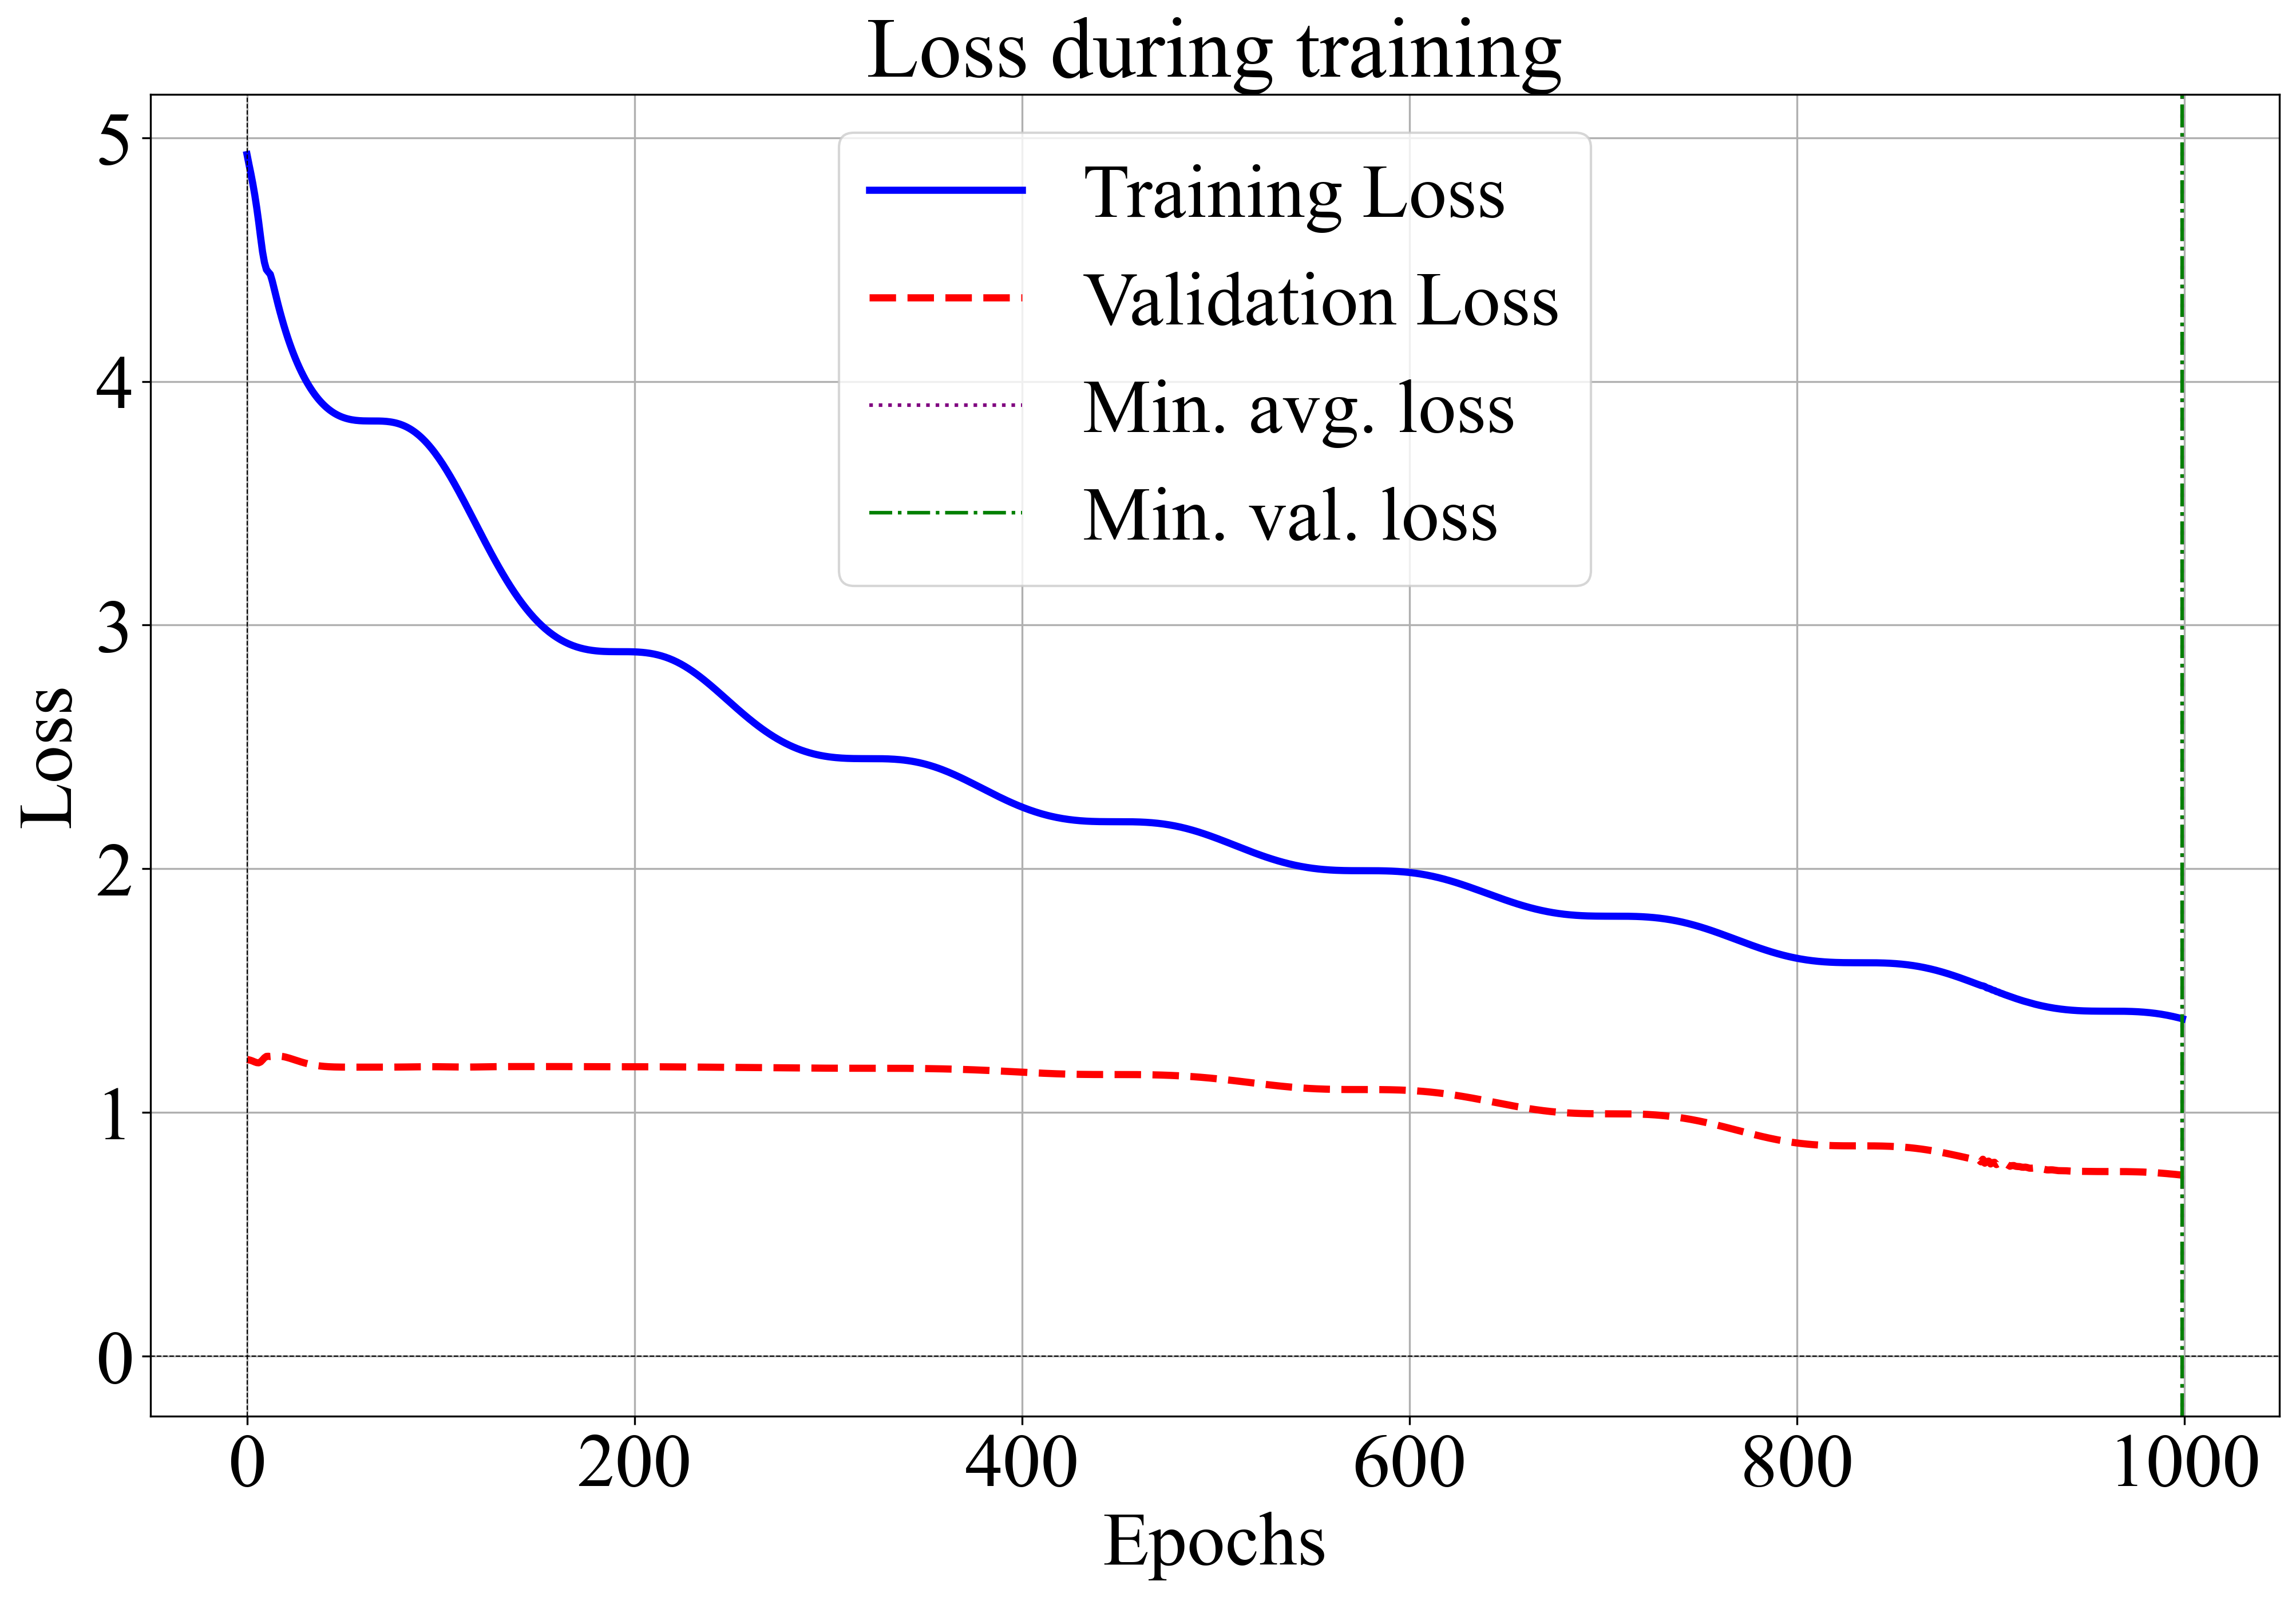

Points added: 10 of 14
Current time: 18:55:07 14-02-2025
Pf: 0.000% - Pf interval: [0.000, 0.000]%
delta: nan%

Iteration 1
Early stopping at epoch 653
Best Loss: 1.8605912923812866 at epoch 551. Training loss: 1.5660426616668701 and val. loss: 2.155139923095703
  Training succeeded after 1 attempt(s).
avg loss = 1.8606
  New best model found at fold 1:
    layer sizes: [2], act fun: <class 'torch.nn.modules.activation.Sigmoid'>

Fold: 1, Avg. Loss: 1.8605912923812866

Best Loss: 1.1324374079704285 at epoch 905. Training loss: 1.0375925302505493 and val. loss: 1.2272822856903076
  Training succeeded after 1 attempt(s).
avg loss = 1.1324
  New best model found at fold 2:
    layer sizes: [2], act fun: <class 'torch.nn.modules.activation.Sigmoid'>

Fold: 2, Avg. Loss: 1.1324374079704285

Early stopping at epoch 602
Best Loss: 2.7554644346237183 at epoch 500. Training loss: 2.041203260421753 and val. loss: 3.4697256088256836
  Training succeeded after 1 attempt(s).
avg loss = 2.7555
Fold:

<Figure size 640x480 with 0 Axes>

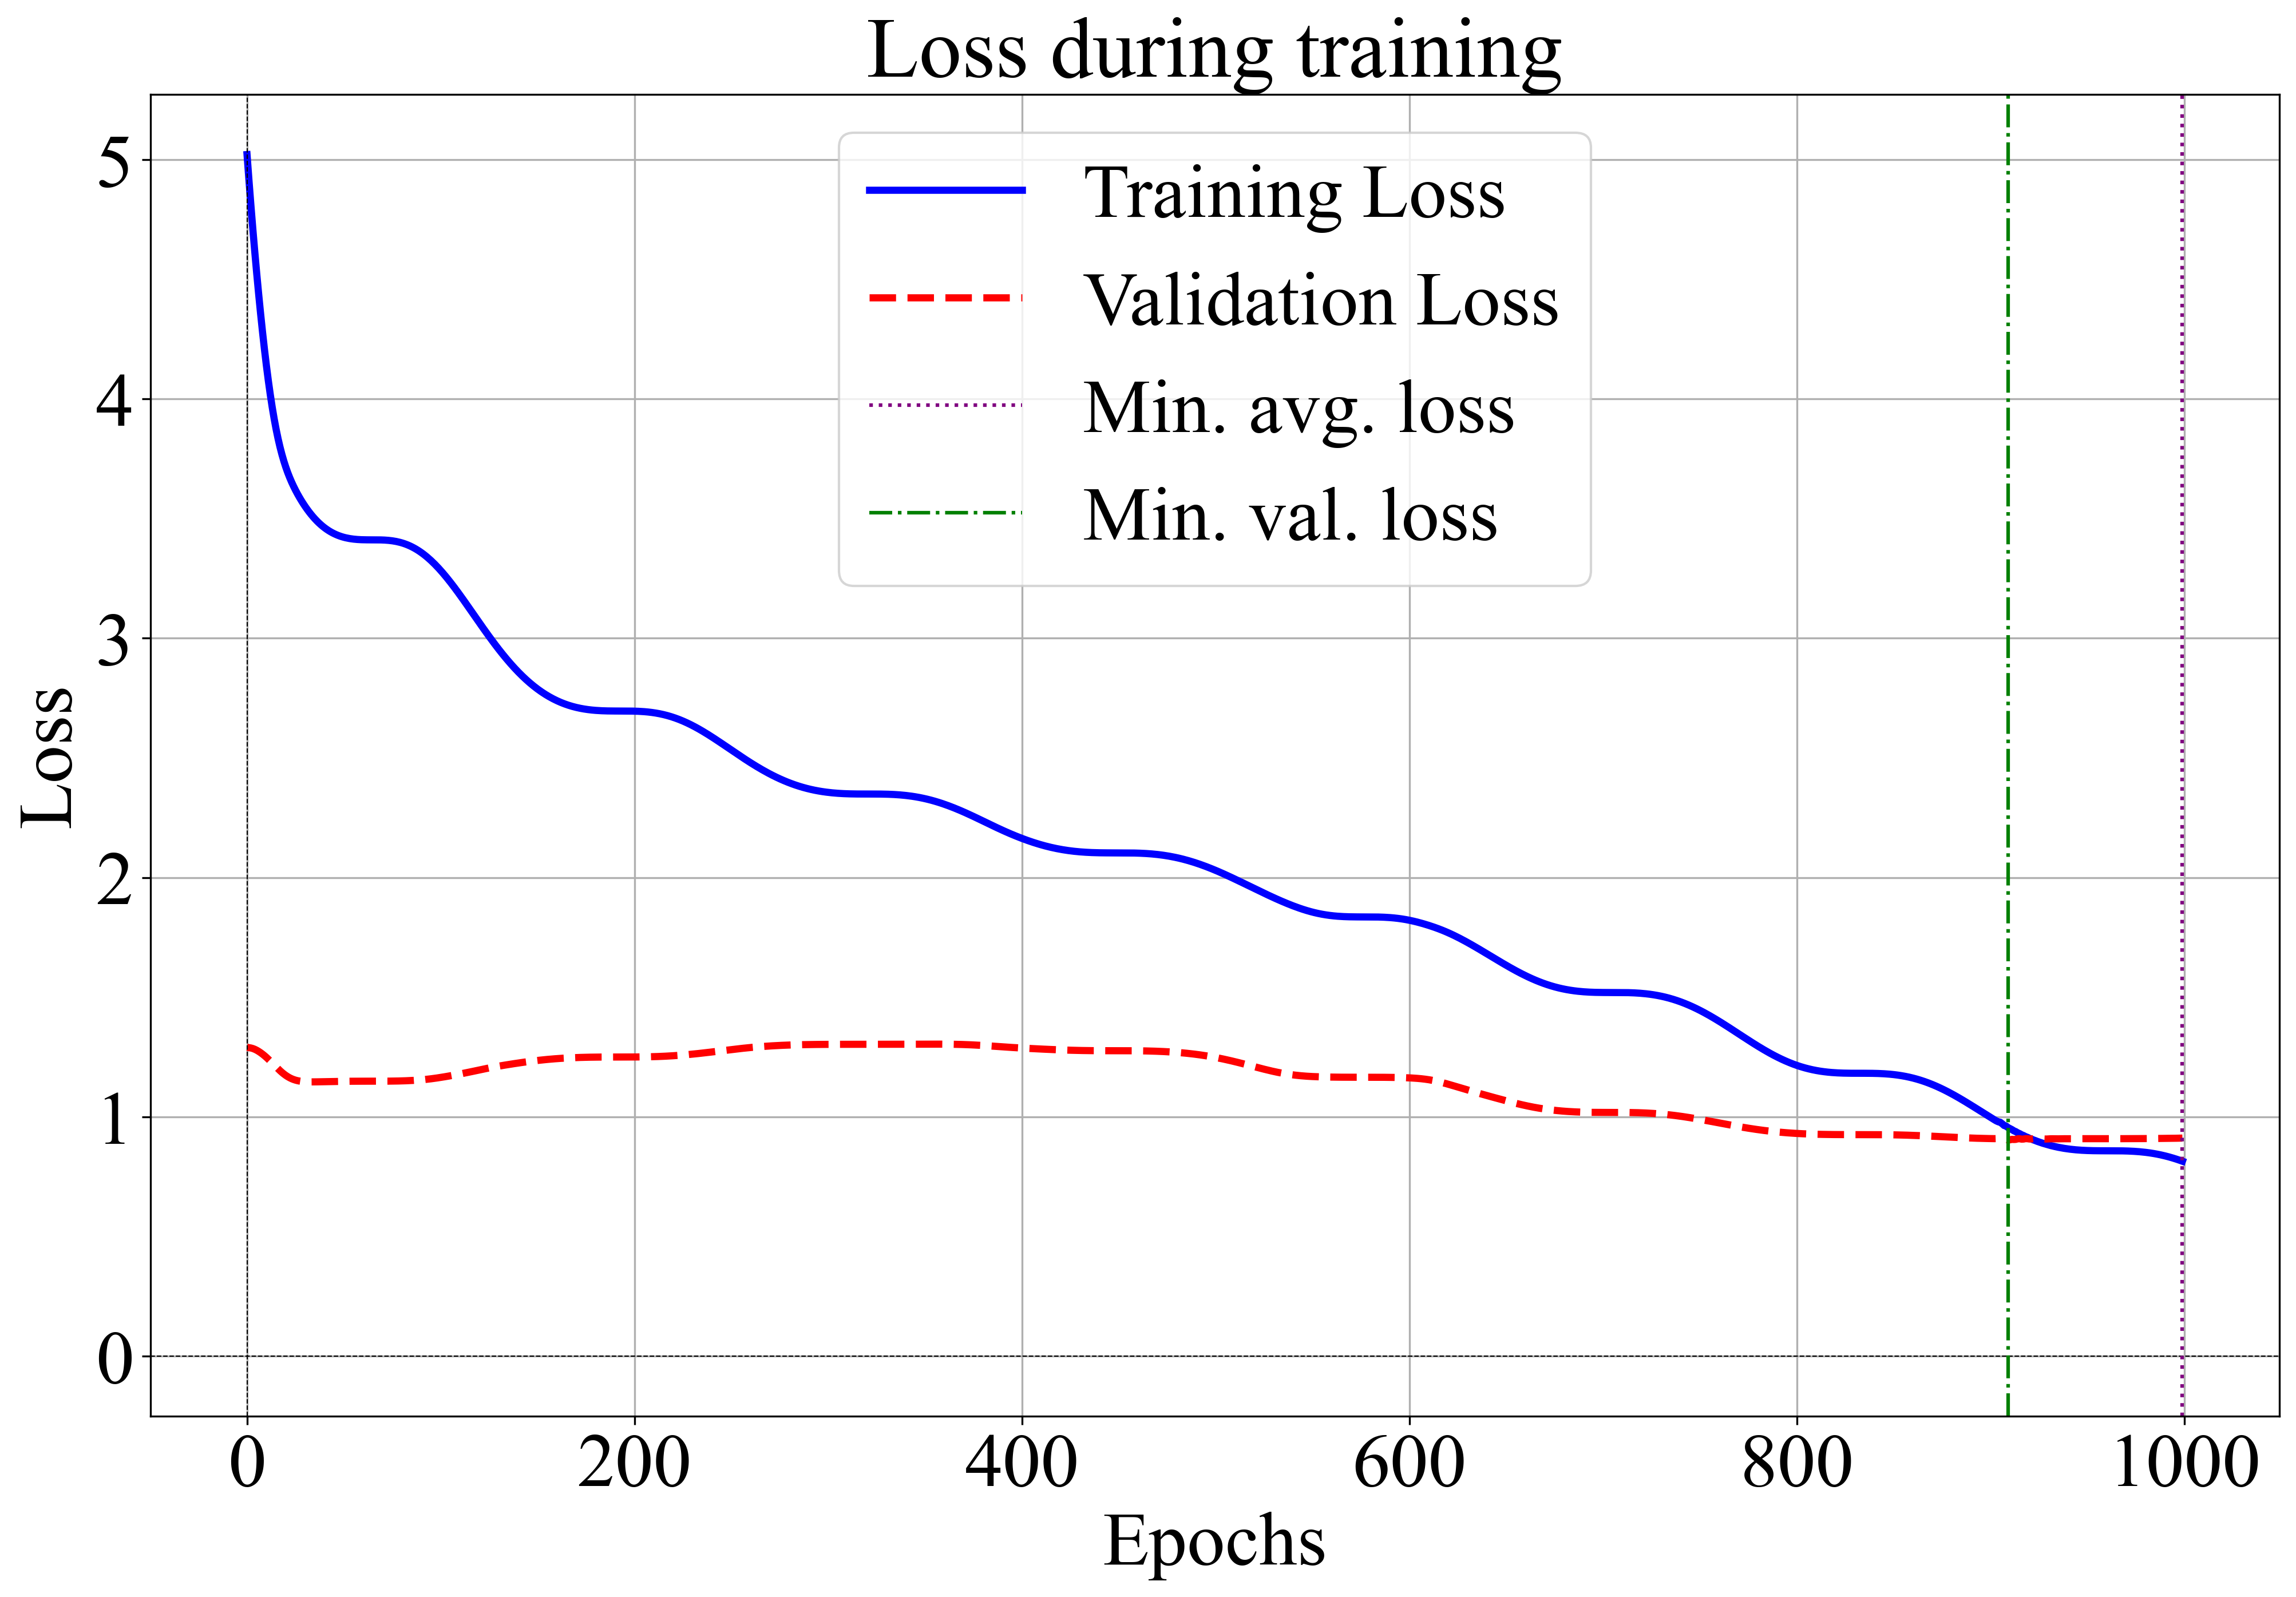

Points added: 11 of 14
Current time: 18:55:34 14-02-2025
Pf: 0.000% - Pf interval: [0.000, 0.000]%
delta: nan%

Iteration 2
Best Loss: 1.0442131161689758 at epoch 999. Training loss: 0.8065593242645264 and val. loss: 1.2818669080734253
  Training succeeded after 1 attempt(s).
avg loss = 1.0442
  New best model found at fold 1:
    layer sizes: [2], act fun: <class 'torch.nn.modules.activation.Sigmoid'>

Fold: 1, Avg. Loss: 1.0442131161689758

Early stopping at epoch 461
Best Loss: 2.9491085410118103 at epoch 359. Training loss: 1.131839632987976 and val. loss: 4.7663774490356445
  Training succeeded after 1 attempt(s).
avg loss = 2.9491
Fold: 2, Avg. Loss: 2.9491085410118103

Early stopping at epoch 678
Best Loss: 1.711241066455841 at epoch 576. Training loss: 1.5007339715957642 and val. loss: 1.921748161315918
  Training succeeded after 1 attempt(s).
avg loss = 1.7112
Fold: 3, Avg. Loss: 1.711241066455841

Early stopping at epoch 453
Best Loss: 1.762096345424652 at epoch 351. Training

<Figure size 640x480 with 0 Axes>

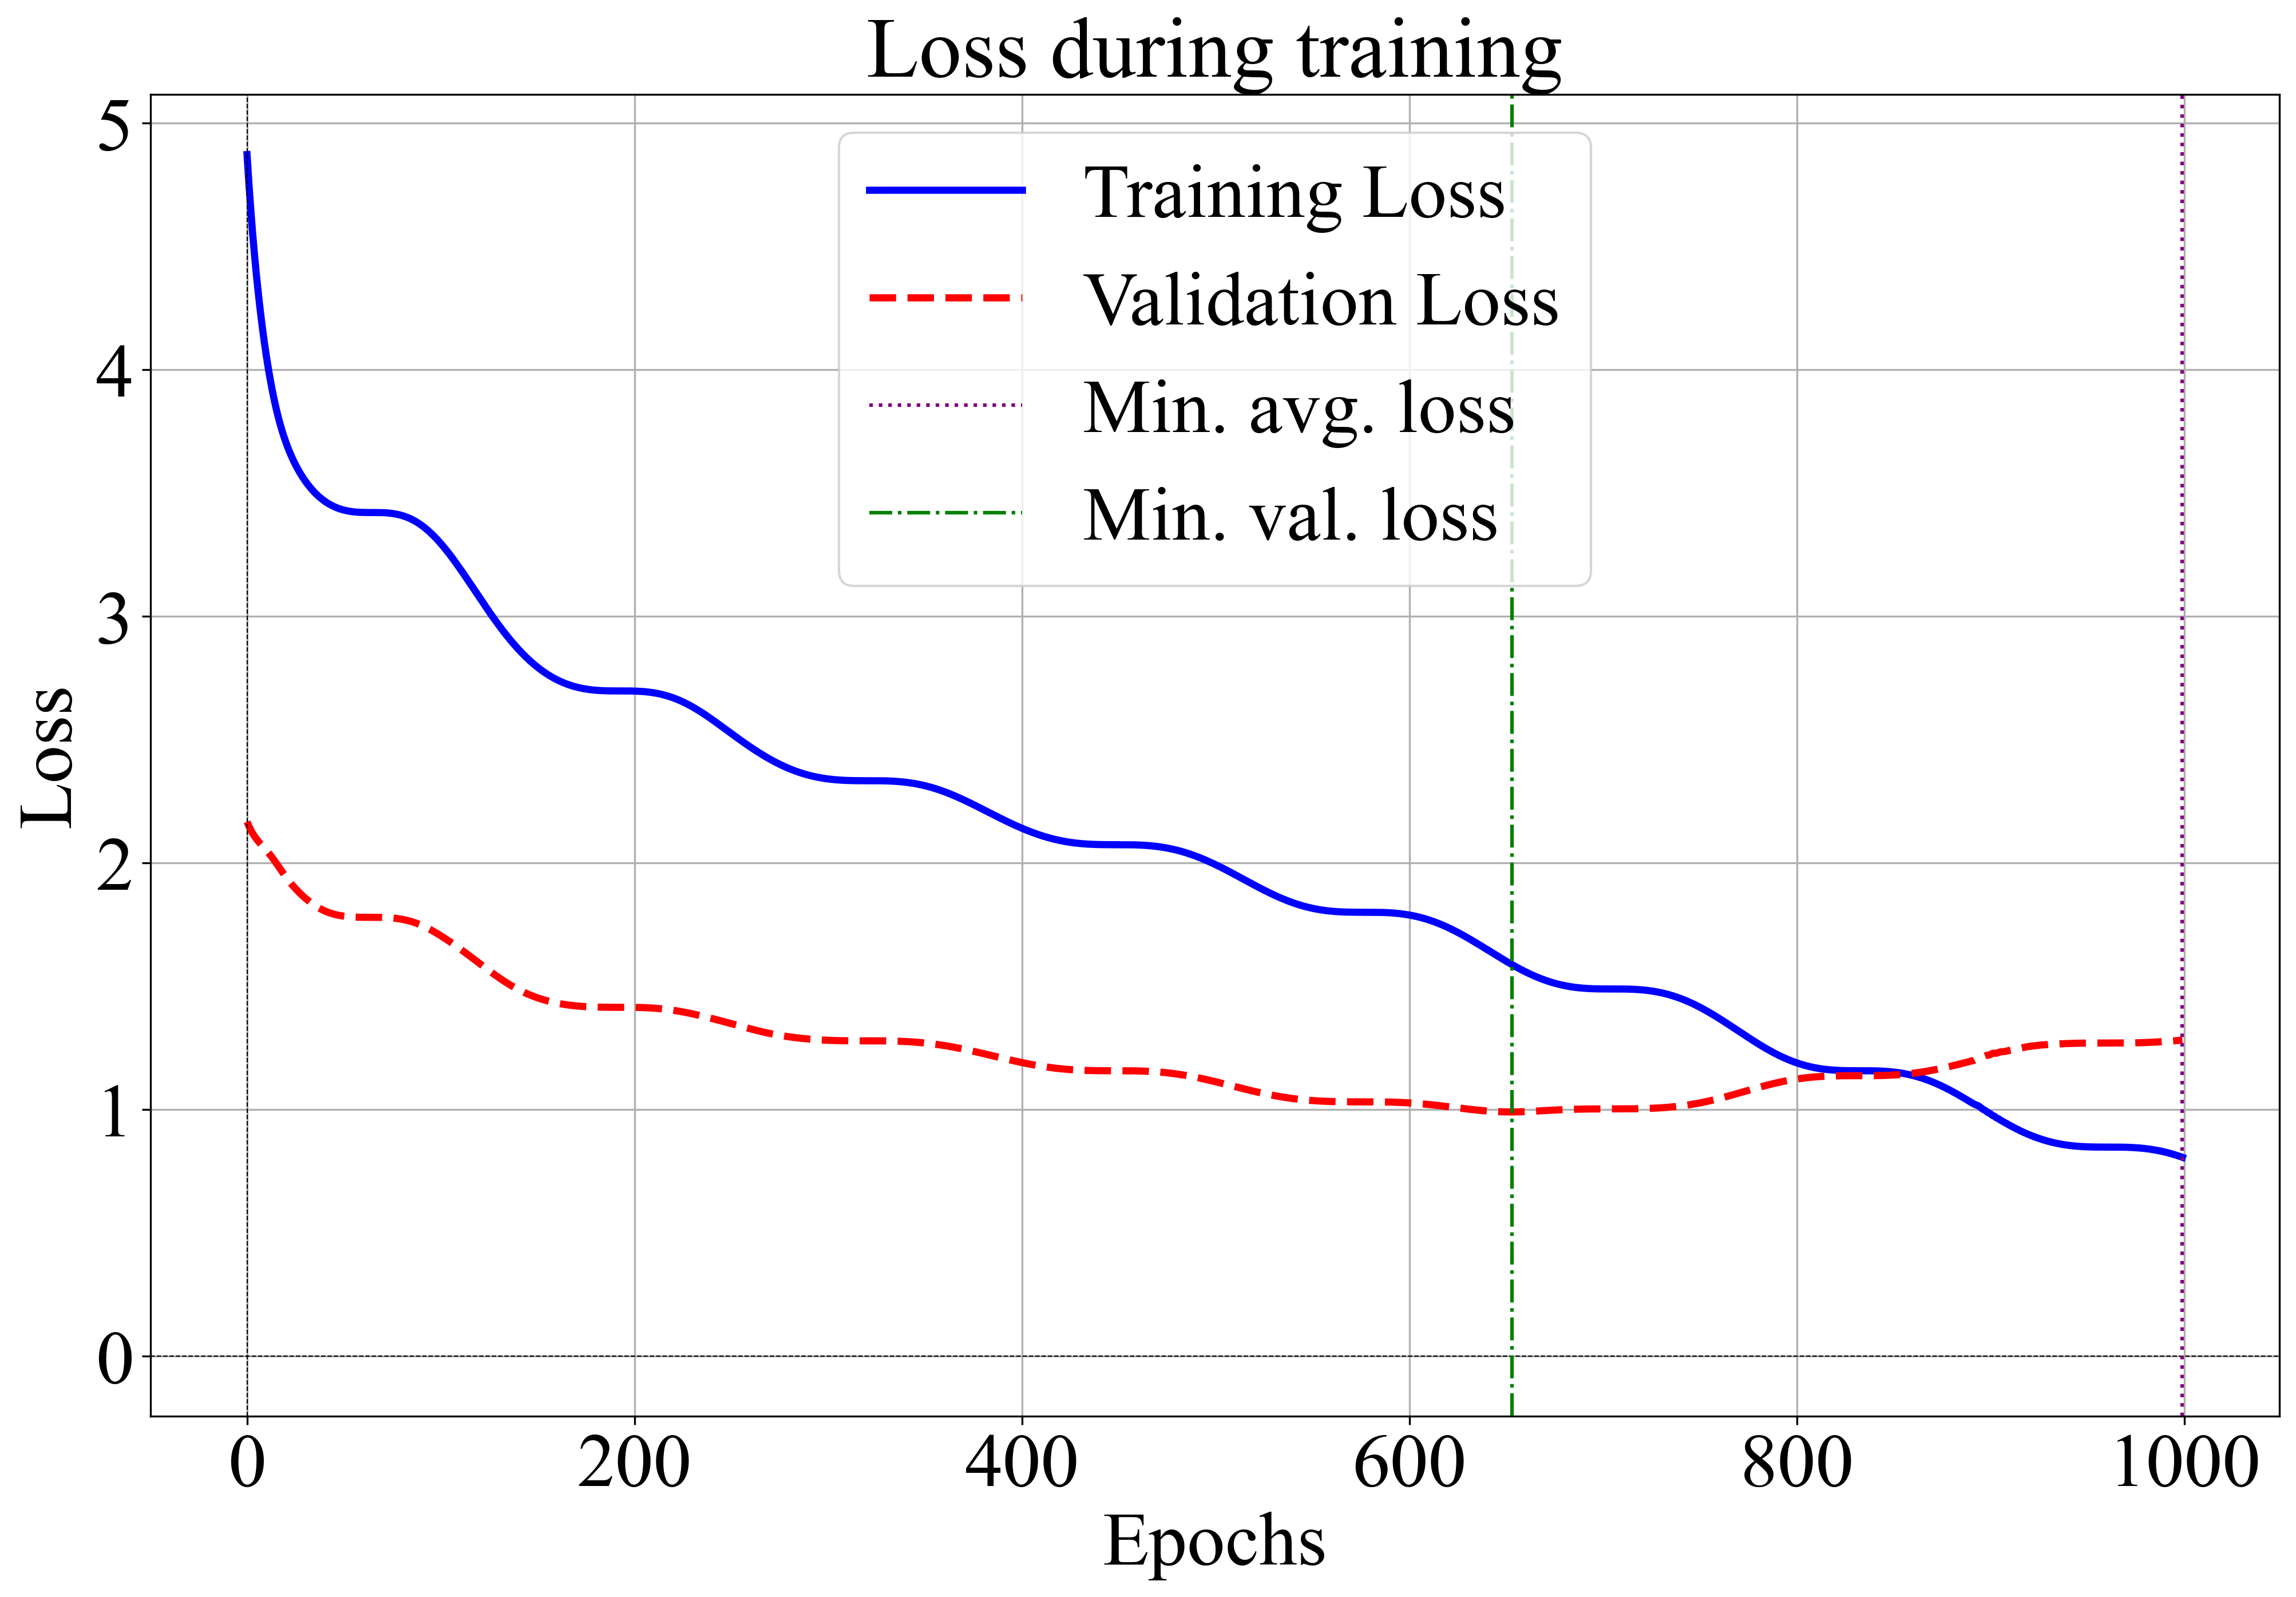

Points added: 12 of 14
Current time: 18:55:58 14-02-2025
Pf: 0.000% - Pf interval: [0.000, 0.001]%
delta: inf%

Iteration 3
Best Loss: 1.0635342001914978 at epoch 999. Training loss: 0.627346396446228 and val. loss: 1.4997220039367676
  Training succeeded after 1 attempt(s).
avg loss = 1.0635
  New best model found at fold 1:
    layer sizes: [2], act fun: <class 'torch.nn.modules.activation.Sigmoid'>

Fold: 1, Avg. Loss: 1.0635342001914978

Early stopping at epoch 143
Best Loss: 4.243525266647339 at epoch 41. Training loss: 2.251924514770508 and val. loss: 6.23512601852417
  Training succeeded after 1 attempt(s).
avg loss = 4.2435
Fold: 2, Avg. Loss: 4.243525266647339

Early stopping at epoch 806
Best Loss: 1.6868136525154114 at epoch 704. Training loss: 1.4308950901031494 and val. loss: 1.9427322149276733
  Training succeeded after 1 attempt(s).
avg loss = 1.6868
Fold: 3, Avg. Loss: 1.6868136525154114

Early stopping at epoch 371
Best Loss: 1.7854183912277222 at epoch 269. Training l

<Figure size 640x480 with 0 Axes>

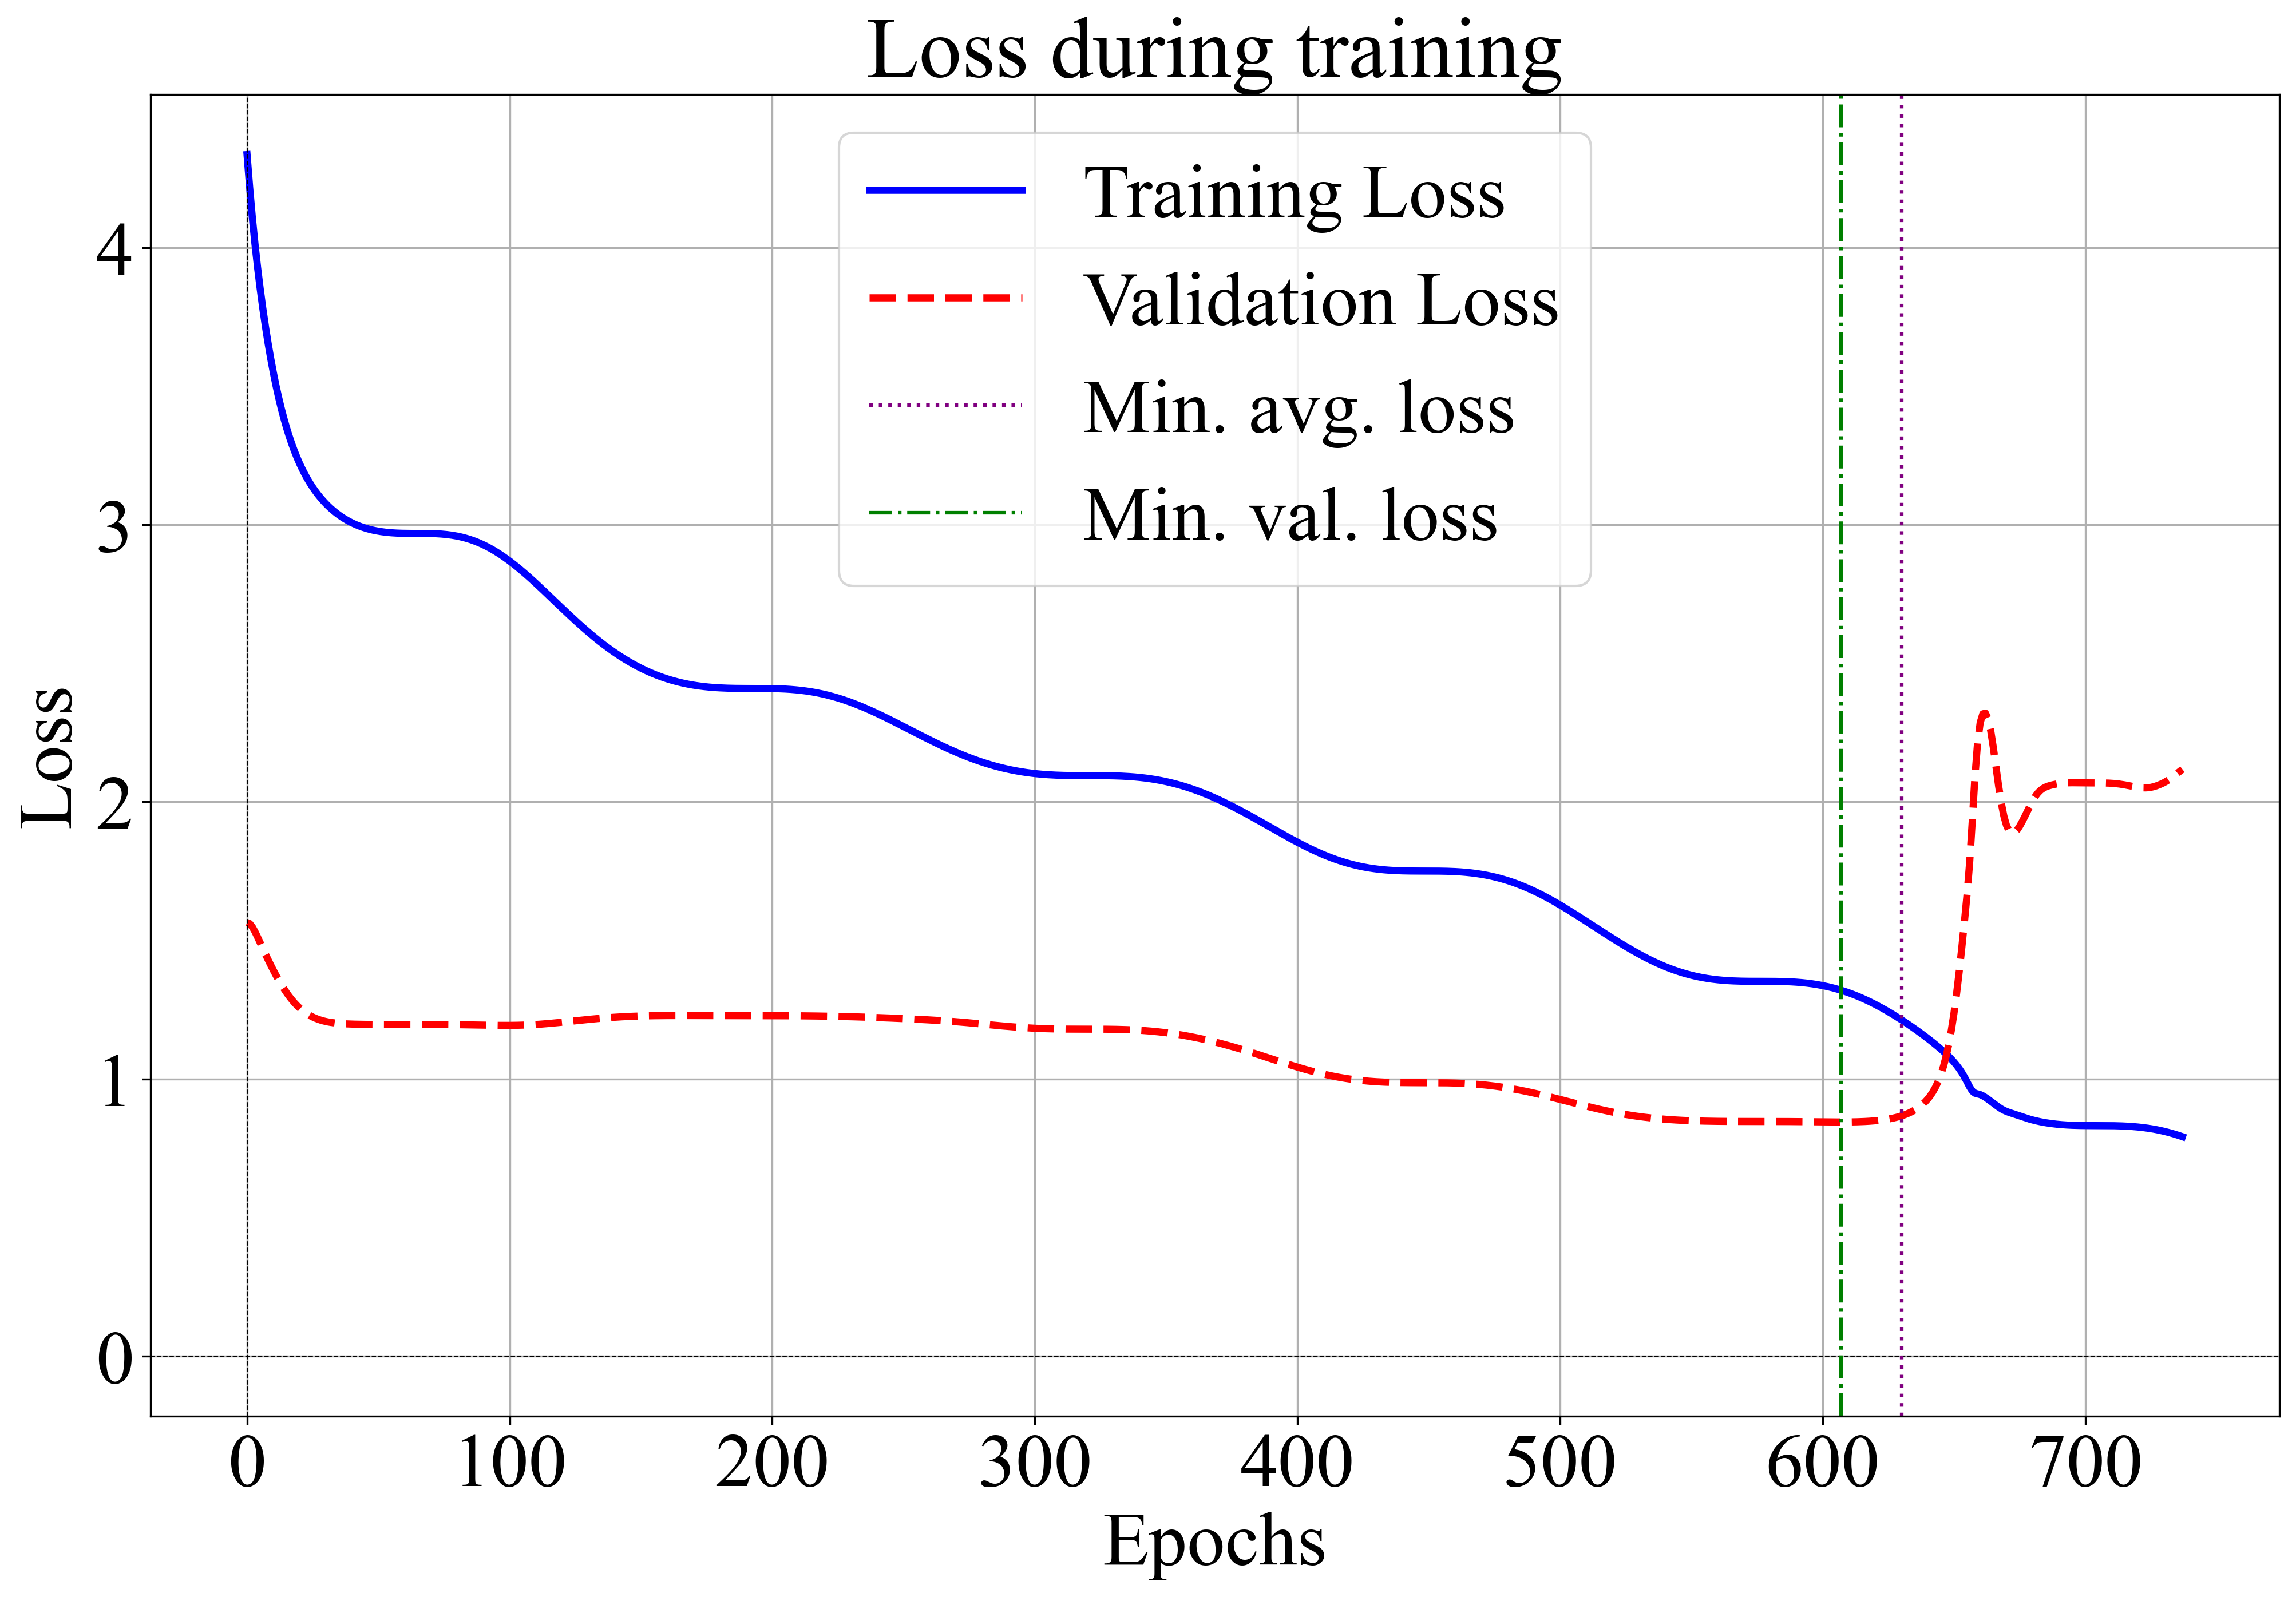

Points added: 13 of 14
Current time: 18:56:21 14-02-2025
Pf: 0.000% - Pf interval: [0.000, 0.000]%
delta: nan%

Iteration 4
Early stopping at epoch 991
Best Loss: 1.4073565304279327 at epoch 889. Training loss: 0.5646265149116516 and val. loss: 2.250086545944214
  Training succeeded after 1 attempt(s).
avg loss = 1.4074
  New best model found at fold 1:
    layer sizes: [2], act fun: <class 'torch.nn.modules.activation.Sigmoid'>

Fold: 1, Avg. Loss: 1.4073565304279327

Early stopping at epoch 119
Best Loss: 3.7142778635025024 at epoch 17. Training loss: 2.4035041332244873 and val. loss: 5.025051593780518
  Training succeeded after 1 attempt(s).
avg loss = 3.7143
Fold: 2, Avg. Loss: 3.7142778635025024

Early stopping at epoch 422
Best Loss: 2.1827582120895386 at epoch 320. Training loss: 2.0246875286102295 and val. loss: 2.3408288955688477
  Training succeeded after 1 attempt(s).
avg loss = 2.1828
Fold: 3, Avg. Loss: 2.1827582120895386

Early stopping at epoch 422
Best Loss: 1.796324551

<Figure size 640x480 with 0 Axes>

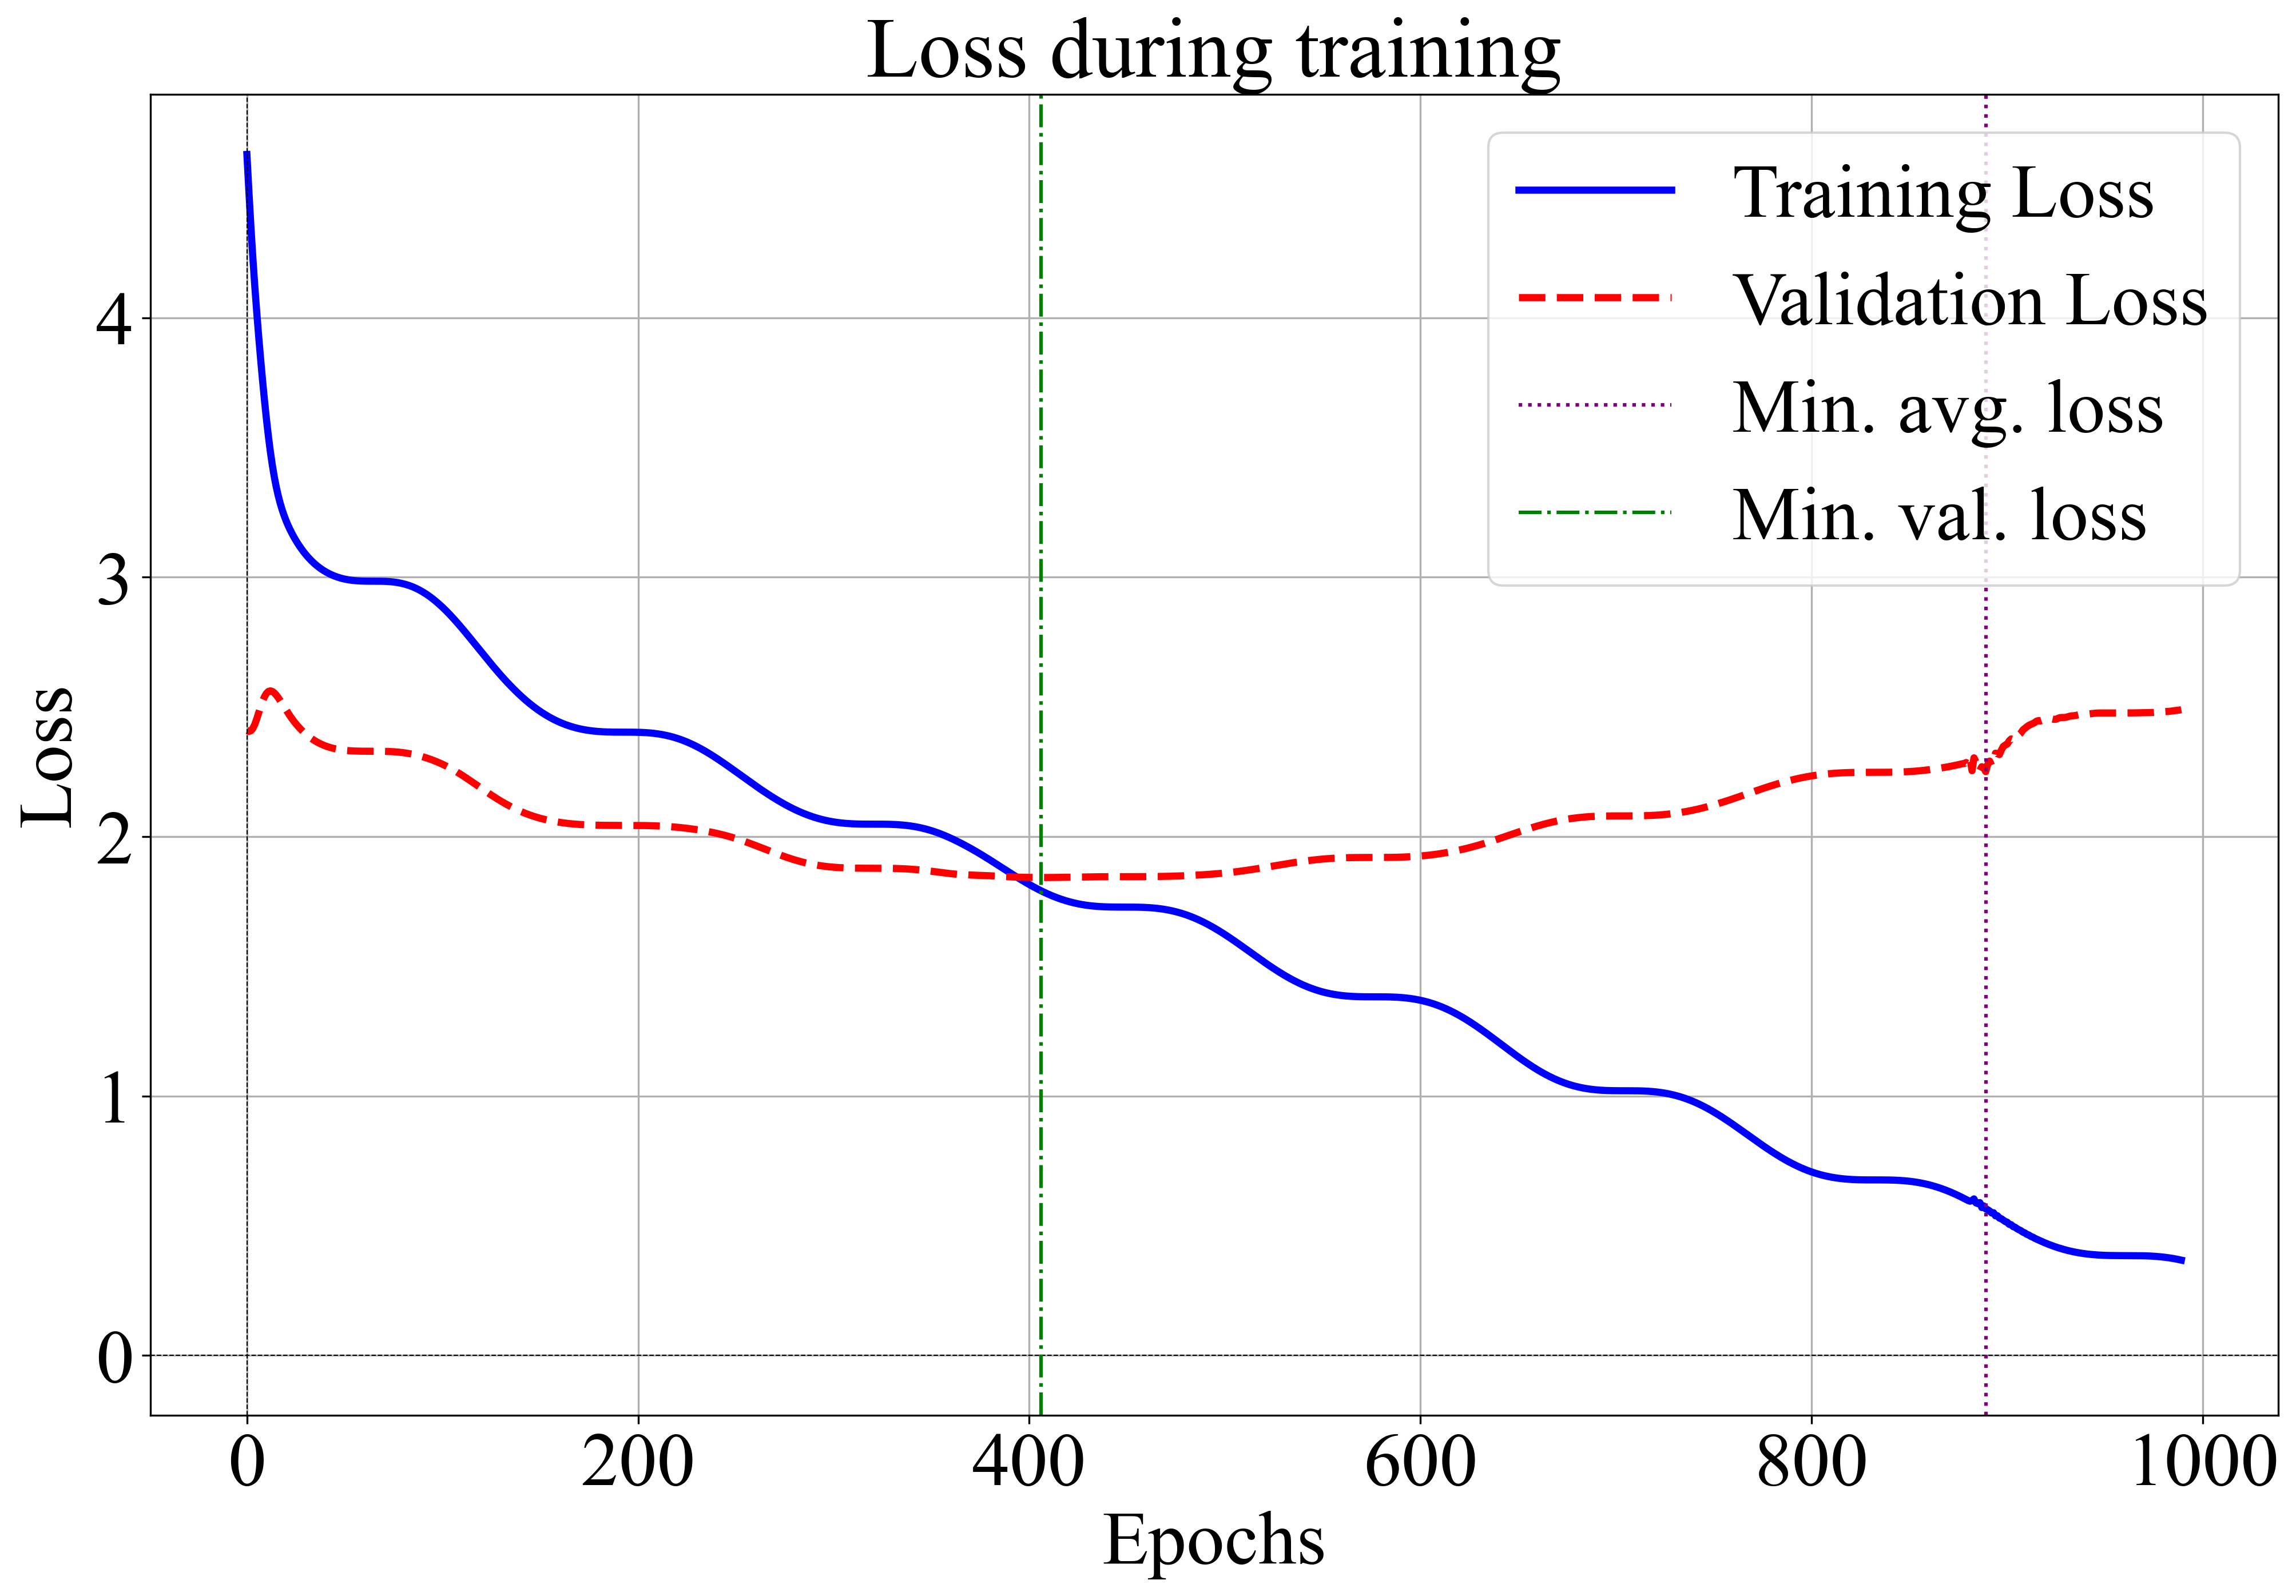

Points added: 14 of 14
Current time: 18:56:40 14-02-2025
Pf: 0.000% - Pf interval: [0.000, 0.054]%
delta: inf%


c:\Users\T-GAMER\Desktop\DOC\Artigo SN\AL-SNDGPR-MCS\core\AL.py:129: RuntimeWarning: invalid value encountered in multiply
  'Pf_CI': estimate_Pf_0 * np.array([


<Figure size 640x480 with 0 Axes>

In [3]:
Results, History, Params = AL(EXAMPLE)

## Display results and plot

In [4]:
results_print(Results, History, Params)

Model evaluations: 14 (10 + 4)
Probability of failure: 0.0
Confidence interval: [nan, nan] (alpha = 0.05)
Beta: inf
CoV:  inf


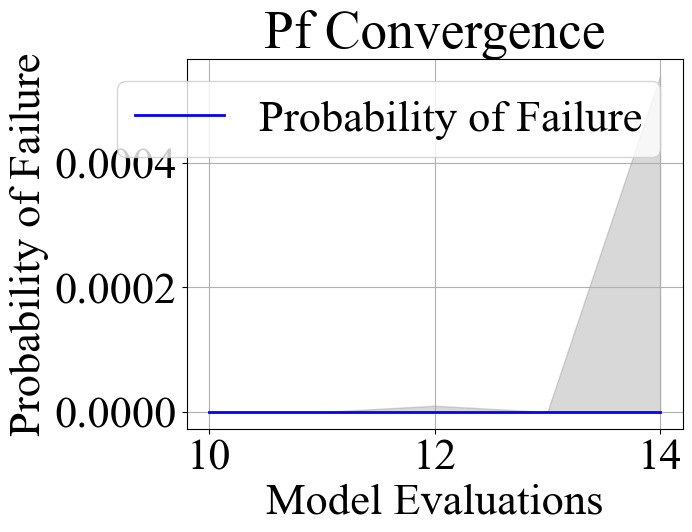

In [6]:
results_plot(History, Params)

## LOAD

In [ ]:
# from core.utils.serialization_utils import pickle_load
# pickle_load(EXAMPLE, ['Results', 'History', 'Params'])